In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook                                                                                                                                               

import matplotlib.pyplot as plt                                                                                                                                                                                                                                                     

from threeML.io.download_from_ftp import download_file_from_ftp
from trigdat_reader import TrigReader
import gbm_drm_gen as drm
from threeML import *                                                                                                                          
from glob import glob                                                                                                                          
import os                                                                                                                                                                                                                                                                                    

import warnings                                                                                                                                
warnings.simplefilter('ignore')                                                                                                                

This is a small and simple tutorial which shows how to simultaneously fit spectrum and location with BALROG for TTE data.

We create a directory and download the data we need. It may take a while, so you may wish to have a look at the trigdat data file and select only the detectors you need for the fit.

In [28]:
trigger = '150430015'

#change path to a directory of your preference
data_path = './'+trigger
    
if not os.path.exists(data_path):                                                                                              
    os.makedirs(data_path)                                                                                                 
    os.chdir(data_path)                                                                                                    
else:                                                                                                                          
    os.chdir(data_path)

We download the trigdat file.

In [5]:
url = 'https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/bursts/2015/bn150430015/current/glg_trigdat_all_bn150430015_v01.fit'

download_file_from_ftp(url,'.')

'./glg_trigdat_all_bn150430015_v01.fit'

We can check the trigdat data to see which detector to use and have a look at the overall lightcurve of the GRB.

<IPython.core.display.Javascript object>


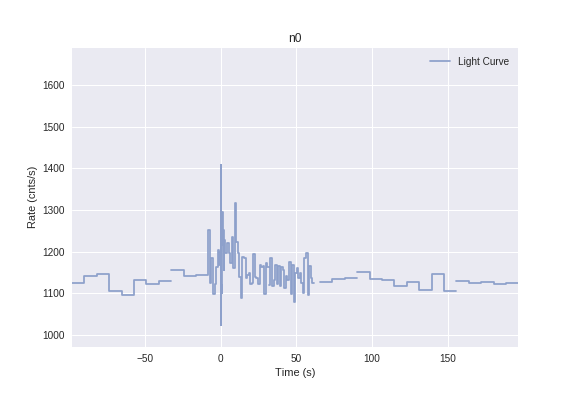

<IPython.core.display.Javascript object>


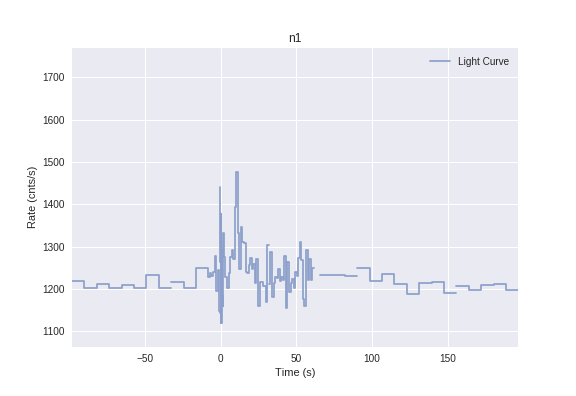

<IPython.core.display.Javascript object>


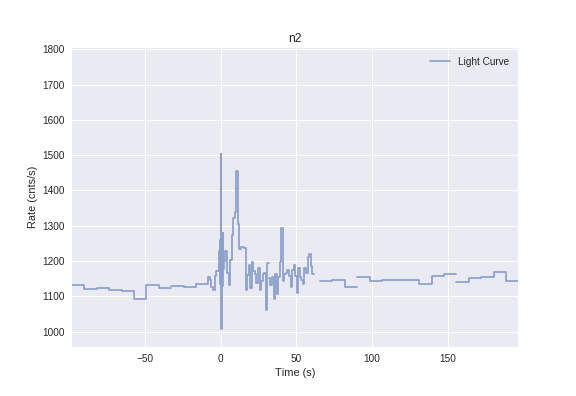

<IPython.core.display.Javascript object>


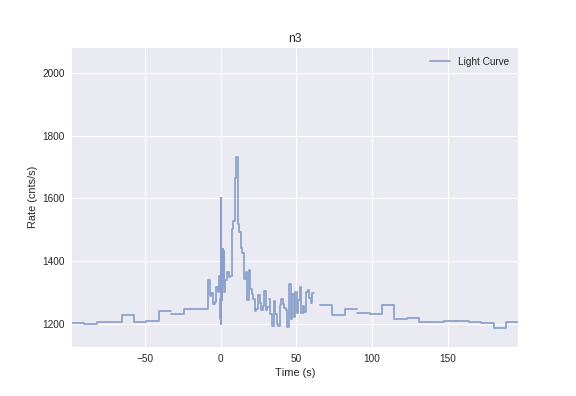

<IPython.core.display.Javascript object>


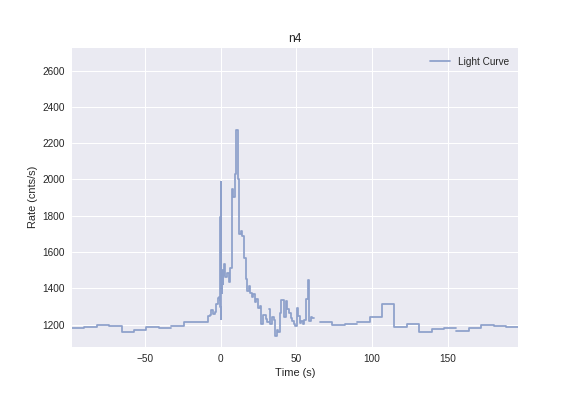

<IPython.core.display.Javascript object>


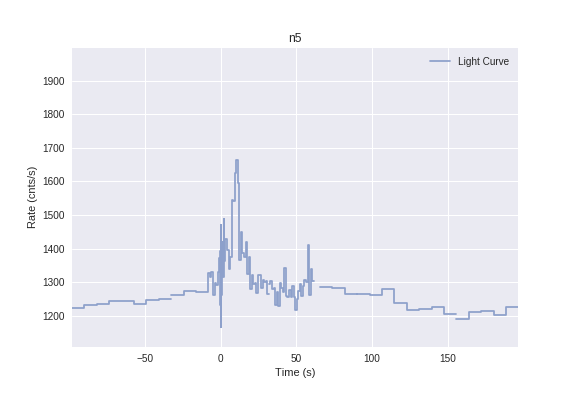

<IPython.core.display.Javascript object>


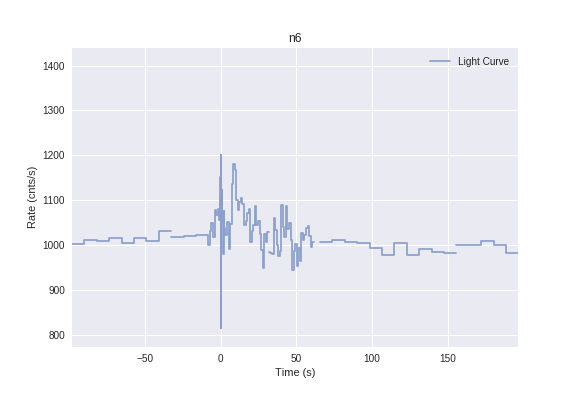

<IPython.core.display.Javascript object>


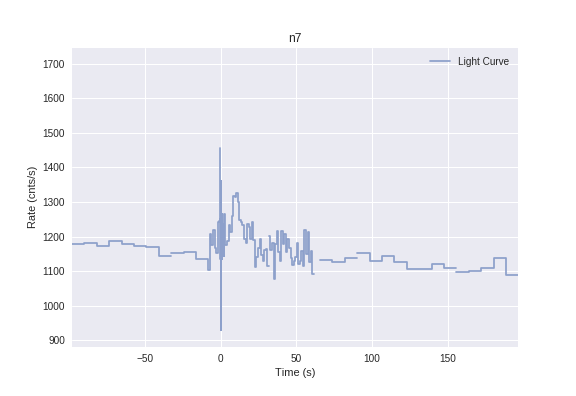

<IPython.core.display.Javascript object>


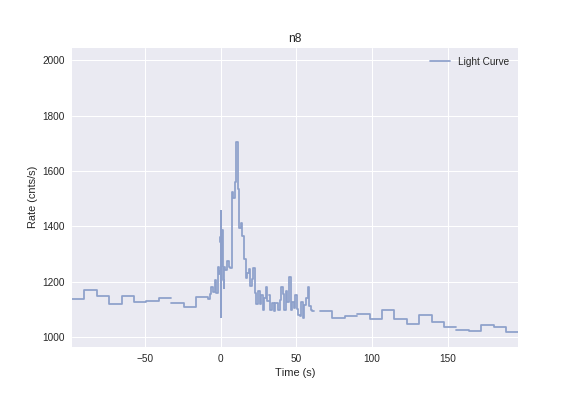

<IPython.core.display.Javascript object>


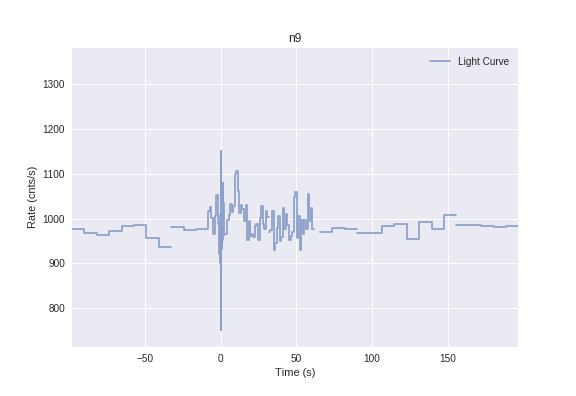

<IPython.core.display.Javascript object>


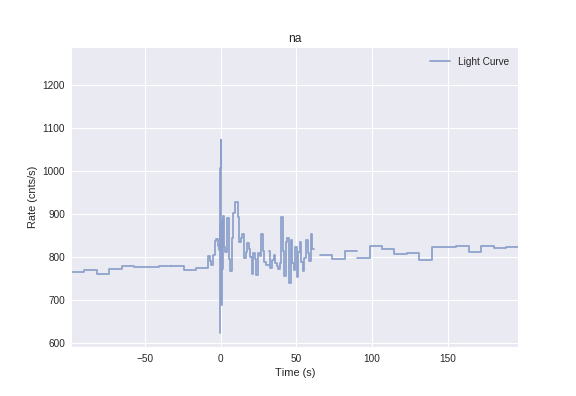

<IPython.core.display.Javascript object>


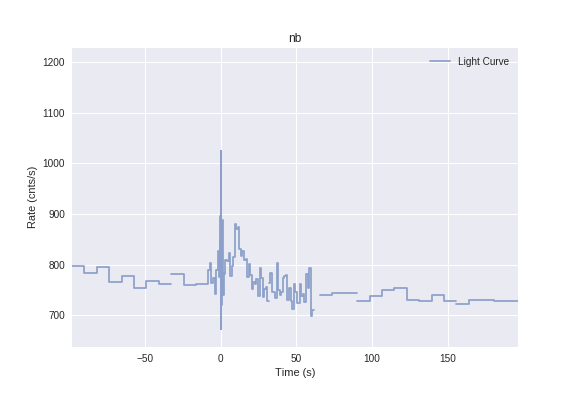

<IPython.core.display.Javascript object>


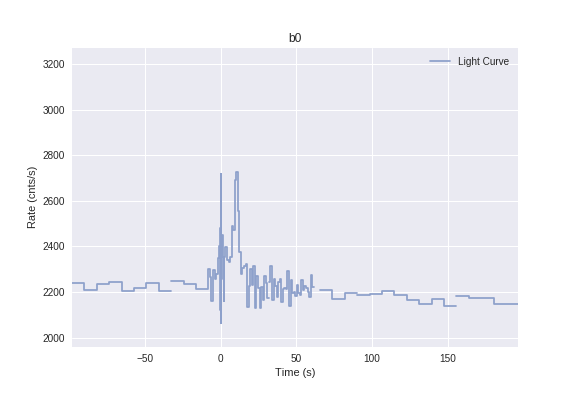

<IPython.core.display.Javascript object>


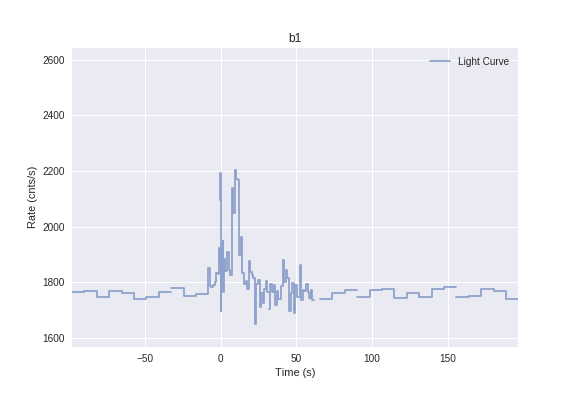

In [8]:
trig_reader = TrigReader(glob('glg_trigdat_all_bn'+trigger+'_v0*.fit')[0], fine=True, verbose=False)
trig_reader.view_lightcurve(start=-100, stop=200)

We select the detector data we want to to download

In [19]:
# Select detector data you wish to download. You can also just download all the data and then choose after having
# a look at TTE lightcurves.
    
det_list = ['n2','n3','n4','n5','n8','b0','b1']

gbm_dl = download_GBM_trigger_data('bn'+trigger, detectors=det_list)

We create the timeseries, we fit the background and select the active time interval. It may be helpful to have a look at the trigdat data to choose which detectors to use. For the active time interval, we roughly select the single most prominent peak. This is an approach that can work well for localization purposes, however keep in mind that the time evolution of the spectrum of the source may not always be negligible.

In [21]:
bkg_int = ['-80--20','50-150']
src_int = ['9.4-12.3']
det_list = ['n2','n3','n4','n5','n8','b0','b1']

#we store the time series in a dictionary
det_ts = dict()

for det in det_list:                                                            
    # Remember to remove the .gz extension if you are using uncompressed tte files
    tte_file = glob('glg_tte_'+det+'_bn'+trigger+'_v0*.fit.gz')[0]                 
    rsp_file = glob('glg_cspec_'+det+'_bn'+trigger+'_v0*.rsp*')[0]              

    ts = TimeSeriesBuilder.from_gbm_tte(det, tte_file, rsp_file)                
    ts.set_background_interval(*bkg_int)                                        
    ts.set_active_time_interval(*src_int)                                       
    det_ts[det] = ts
    
del ts

Auto-determined polynomial order: 1




Unbinned 1-order polynomial fit with the Nelder-Mead method


Auto-determined polynomial order: 2




Unbinned 2-order polynomial fit with the Nelder-Mead method


Auto-determined polynomial order: 3




Unbinned 3-order polynomial fit with the Nelder-Mead method


Auto-determined polynomial order: 2




Unbinned 2-order polynomial fit with the Nelder-Mead method


Auto-determined polynomial order: 1




Unbinned 1-order polynomial fit with the Nelder-Mead method


Auto-determined polynomial order: 1




Unbinned 1-order polynomial fit with the Nelder-Mead method


Auto-determined polynomial order: 0




Unbinned 0-order polynomial fit with the Nelder-Mead method




We can check the lightcurvers of the detectors. It is also possible to use custom binning (see https://threeml.readthedocs.io/en/latest/notebooks/Building_Plugins_from_TimeSeries.html). This GRB presents a complex lightcurve (especially noticeable at finer time resolution), so you may want to play around a bit with the active time selection. Here we show a rough selection which still allows for a good localization.

<IPython.core.display.Javascript object>


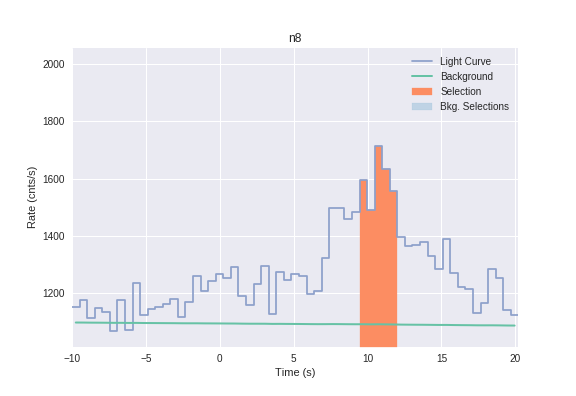

<IPython.core.display.Javascript object>


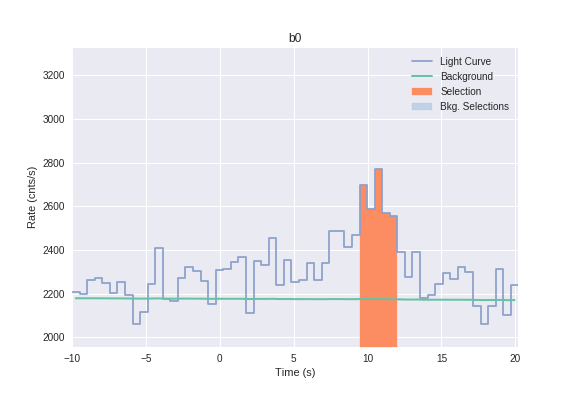

<IPython.core.display.Javascript object>


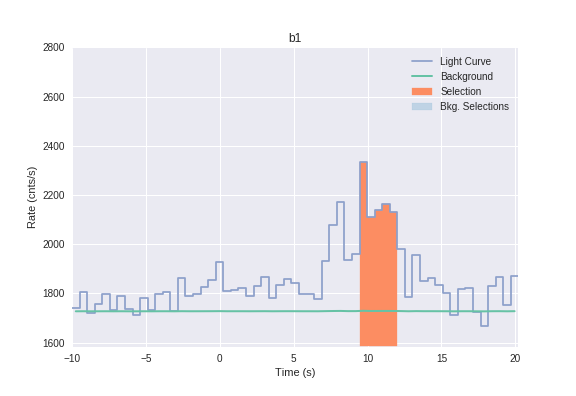

<IPython.core.display.Javascript object>


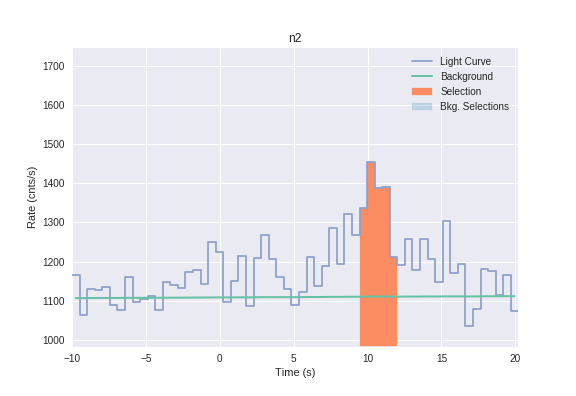

<IPython.core.display.Javascript object>


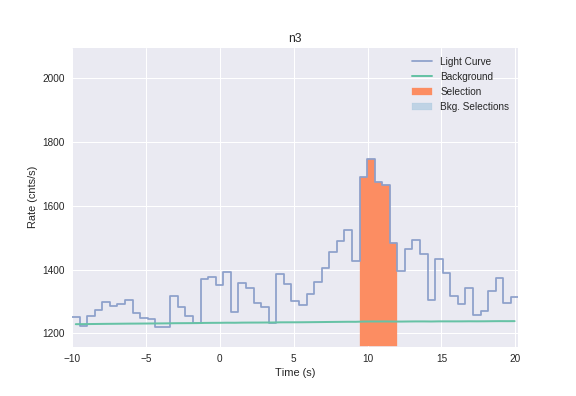

<IPython.core.display.Javascript object>


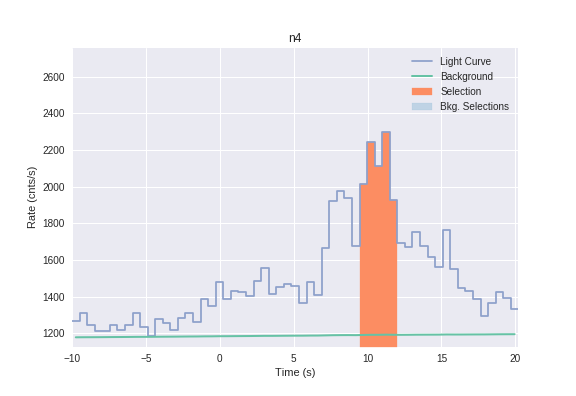

<IPython.core.display.Javascript object>


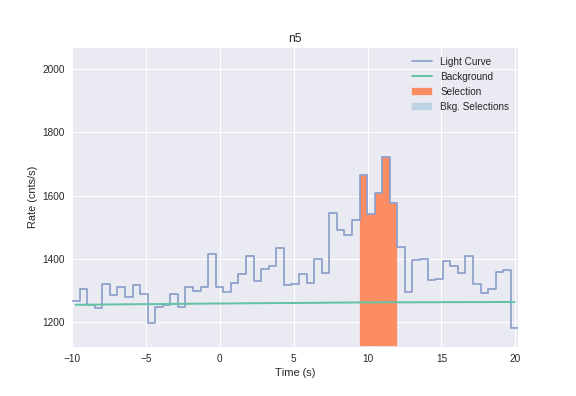

In [24]:
for key in det_ts.keys():
    det_ts[key].view_lightcurve(start=-10, stop=20, dt=0.512)
    plt.title(key)

We select the energy range we want to use: it is important to exclude the lowest and highest
energy channels due to inaccurate response or overflow.

In [25]:
det_sl = dict()

for key in det_ts.keys():
    if key != 'b0' and key != 'b1':
        sl = det_ts[key].to_spectrumlike()
        sl.set_active_measurements('8.1-900')
        det_sl[key] = sl
    else:
        sl = det_ts[key].to_spectrumlike()
        sl.set_active_measurements('250-30000')
        det_sl[key] = sl

Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 8.1-900 translates to channels 3-124
Now using 122 channels out of 128
Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 250-30000 translates to channels 1-119
Now using 119 channels out of 128
Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 250-30000 translates to channels 4-119
Now using 116 channels out of 128
Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 8.1-900 translates to channels 3-124
Now using 122 channels out of 128
Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 8.1-900 translates to channels 4-124
Now using 121 channels out of 128
Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 8.1-900 translates to channels 4-123
Now using 120 channels out of 128
Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 8.1-900 translates to ch

<IPython.core.display.Javascript object>


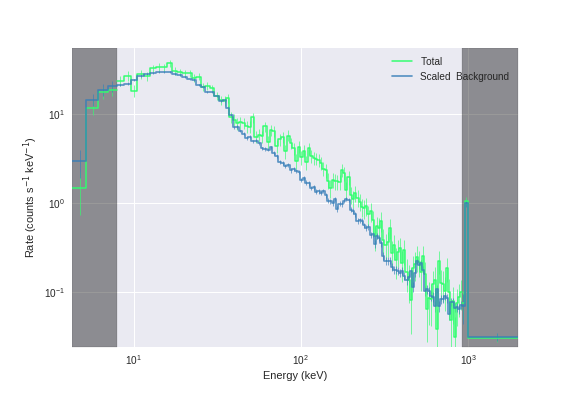

In [26]:
# We can check the count spectrum of the detectors, e.g.
det_sl['n5'].view_count_spectrum();

We set up the TTE response generator to be used in the fit.

In [34]:
det_rsp = dict()

for det in det_list:
    rsp = drm.DRMGenTTE(tte_file=glob('glg_tte_'+det+'_bn'+trigger+'_v0*.fit.gz')[0],                                                                           
                        trigdat=glob('glg_trigdat_all_bn'+trigger+'_v0*.fit')[0],                                                                                 
                        mat_type=2,                                                                                                                     
                        cspecfile=glob('glg_cspec_'+det+'_bn'+trigger+'_v0*.pha')[0])
    
    det_rsp[det] = rsp
    
del rsp

We finally create the BALROG plugins for the detectors we use for the fit.

In [35]:
det_bl = dict()
#set the time at which the repsonse is calculated (roughly the center of the active time interval in most cases)
rsp_time = 11.

for det in det_list:
    det_bl[det] = drm.BALROGLike.from_spectrumlike(det_sl[det], rsp_time, det_rsp[det], free_position=True)

Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-probed noise models:
- observation: poisson
- background: gaussian


We set up the model we wish to use for the fit.

In [36]:
data = DataList(*det_bl.values())

#you can set whatever you want as a starting position for MULTINEST, it is not important 
ra = 10.
dec = 10.

band = Band()                                                                                                                              
                                                                                                                                               
band.K.prior = Log_uniform_prior(lower_bound=1e-5, upper_bound=500)                                                                        
band.xp.prior = Log_uniform_prior(lower_bound=10, upper_bound=1e4)                                                                         
band.alpha.set_uninformative_prior(Uniform_prior)                                                                                          
band.beta.set_uninformative_prior(Uniform_prior)                                                                                           
                                                                                                                                               
model = Model(PointSource('grb',ra,dec,spectral_shape=band))
                                                                                                                                                                                                                                                                                       
bayes = BayesianAnalysis(model, data)

Freeing the position of n8 and setting priors
Freeing the position of b0 and setting priors
Freeing the position of b1 and setting priors
Freeing the position of n2 and setting priors
Freeing the position of n3 and setting priors
Freeing the position of n4 and setting priors
Freeing the position of n5 and setting priors


We can then run MULTINEST to sample the posterior distribution for our source (spectrum+location).

In [ ]:
_ =bayes.sample_multinest(800,                                                                                                                 
                        chain_name='chains/',                                                                                     
                        importance_nested_sampling=False,                                                                                      
                        const_efficiency_mode=False,                                                                                           
                        wrapped_params=wrap,                                                                                                   
                        verbose=True,                                                                                                          
                        resume=False)

This particular GRB has been detected by Swift and thus a reference position is available to check the accuracy of the fit (RA = 326.4796 deg, DEC = -27.9021 deg).